In [1]:
import torch
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizerFast
from tokenizers import BertWordPieceTokenizer
from itertools import compress
torch.set_printoptions(sci_mode=False, threshold=10_000)

2025-08-19 16:21:52.710913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 16:21:53.219037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-19 16:21:53.455116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-19 16:21:53.534786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-19 16:21:53.928047: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
#Get and Preprocess Data by line
def read_txt(txt_path):
  with open(txt_path, 'r') as f:
    txt_string = f.readlines()
  return txt_string

poem_list = []
nump_poems = 13853
for i in range(nump_poems+1):
    txt_string = read_txt('Poems/'+str(i)+'.txt')
    # print(txt_string)
    # split_poem = [ [y.lower() for y in sentence.split(' ') if y] for sentence in txt_string]
    poem = ''
    for i in range(len(txt_string)):
      if txt_string[i] == '\n':
        txt_string[i] = ''
        continue
      if txt_string[i].count('\n') == 1 and len(txt_string[i]) > 2:
         txt_string[i] = txt_string[i][:-1] + ' \n '
      poem += txt_string[i]
    poem_list.append(poem)

title_list = []
for i in range(nump_poems+1):
    txt_string = read_txt('Titles/'+str(i)+'.txt')
    # print(txt_string)
    # split_poem = [ [y.lower() for y in sentence.split(' ') if y] for sentence in txt_string]
    title = ''
    for i in range(len(txt_string)):
      if txt_string[i] == '\n':
        txt_string[i] = ''
        continue
      if txt_string[i].count('\n') == 1 and len(txt_string[i]) > 2:
         txt_string[i] = txt_string[i][:-1] + ' \n '
      title += txt_string[i]
    title_list.append(title)

In [ ]:
#Preprocess Data by line for poem line pairs
def clean_line(line):
    if line.count('\n') == 1 and len(line) > 2:
        line = line[:-1] + ' \n '
    return line
    
        
poem_pairs = []
for i in range(nump_poems+1):
    txt_string = read_txt('Poems/'+str(i)+'.txt')
    for x in range(len(txt_string)):
        if(x!=(len(txt_string)-1)):
            line = txt_string[x]
            if line == '\n':
                continue
            line = clean_line(line)
            next_idx = x+1
            next_line = txt_string[next_idx]
            while next_line == '\n' and next_idx!=(len(txt_string)-1):
                next_idx += 1
                next_line = txt_string[next_idx]
            next_line = clean_line(next_line)

            line_pair = (line, next_line)
        poem_pairs.append(line_pair)

In [ ]:
#Creating entire corpus
for i in range(len(poem_list)):
    with open("revised_corpus.txt", 'a') as f:
        f.write(poem_list[i])
for i in range(len(title_list)):
    with open("title_corpus.txt", 'a') as f:
        f.write(title_list[i])

In [7]:
# Tokenizer parameters
VOCAB_SIZE = 50000
MIN_FREQUENCY = 10
LIMIT_ALPHABET = 6000 # How many initial characters to look at
SPECIAL_TOKENS = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
poem_tokenizer_output_dir = Path(f'poem_vocab_{VOCAB_SIZE}')
poem_tokenizer_output_dir.mkdir(exist_ok=True)
title_tokenizer_output_dir = Path(f'title_vocab_{VOCAB_SIZE}')
title_tokenizer_output_dir.mkdir(exist_ok=True)

In [ ]:
# # --- Train Tokenizer ---

# poem_tokenizer_trainer = BertWordPieceTokenizer(strip_accents=False, lowercase=False)

# print("Training tokenizer...")
# poem_tokenizer_trainer.train(
#     files=['revised_corpus.txt'],
#     vocab_size=VOCAB_SIZE,
#     min_frequency=MIN_FREQUENCY,
#     limit_alphabet=LIMIT_ALPHABET,
#     show_progress=True,
#     special_tokens=SPECIAL_TOKENS
# )
# poem_tokenizer_trainer.save_model(str(poem_tokenizer_output_dir))
# print(f"poem tokenizer saved to: {poem_tokenizer_output_dir}")

# title_tokenizer_trainer = BertWordPieceTokenizer(strip_accents=False, lowercase=False)

# print("Training tokenizer...")
# title_tokenizer_trainer.train(
#     files=['revised_corpus.txt'],
#     vocab_size=VOCAB_SIZE,
#     min_frequency=MIN_FREQUENCY,
#     limit_alphabet=LIMIT_ALPHABET,
#     show_progress=True,
#     special_tokens=SPECIAL_TOKENS
# )
# title_tokenizer_trainer.save_model(str(title_tokenizer_output_dir))
# print(f"title tokenizer saved to: {title_tokenizer_output_dir}")


In [9]:
poem_tokenizer = BertTokenizerFast.from_pretrained(
    str(poem_tokenizer_output_dir),
    strip_accents=False,
    lowercase=False
)

title_tokenizer = BertTokenizerFast.from_pretrained(
    str(title_tokenizer_output_dir),
    strip_accents=False,
    lowercase=False
)

In [ ]:
# Dataset for poems and titles
#Create Dataset
class Dataset():
    def __init__(self, txt, title, txt_tokenizer, title_tokenizer, max_length):
        self.poems = txt
        self.titles = title
        self.txt_tokenizer = txt_tokenizer
        self.title_tokenizer = title_tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return(len(self.poems))
    
    def __getitem__(self, idx):
        poem = self.poems[idx]
        title = self.titles[idx]
        sentence_in_token = self.txt_tokenizer.encode(poem, add_special_tokens=True, truncation=True, max_length=self.max_length)
        title_in_token = self.title_tokenizer.encode(title, add_special_tokens=True, truncation=False)
        source = title_in_token
        target_output = sentence_in_token[:-1]
        target_shifted = sentence_in_token[1:]
        return torch.tensor(source), torch.tensor(target_output), torch.tensor(target_shifted)
dataset = Dataset(poem_list, title_list, poem_tokenizer, title_tokenizer, 200)
len(dataset)

# Test Dataset
# input, targets = dataset[0]
# print(f"  Source IDs: {input}")
# print(f"  Source Decoded: {tokenizer.decode(input)}")
# print(f"  Source IDs: {targets}")
# print(f"  Source Decoded: {tokenizer.decode(targets)}")


13854

In [ ]:
#Dataset for pairs of lines in poems
class Poem_pairs_Dataset():
    def __init__(self, pairs, txt_tokenizer, max_length=100):
        self.pairs = pairs
        self.txt_tokenizer = txt_tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return(len(self.pairs))
    
    def __getitem__(self, idx):
        src_line = self.pairs[idx][0]
        tgt_line = self.pairs[idx][1]
        src_in_token = self.txt_tokenizer.encode(src_line, add_special_tokens=True, truncation=False, max_length=100)
        tgt_in_token = self.txt_tokenizer.encode(tgt_line, add_special_tokens=True, truncation=False, max_length=100)
        source = src_in_token
        target_output = tgt_in_token[:-1]
        target_shifted = tgt_in_token[1:]
        return torch.tensor(source), torch.tensor(target_output), torch.tensor(target_shifted)

pairset = Poem_pairs_Dataset(poem_pairs, poem_tokenizer)
len(pairset)

386917

In [13]:
#Collate Function
def collate_fn(raw_batch):
    source, target, shifted_target = zip(*raw_batch)
    return nn.utils.rnn.pack_sequence(source, enforce_sorted=False), nn.utils.rnn.pack_sequence(target, enforce_sorted=False), nn.utils.rnn.pack_sequence(shifted_target, enforce_sorted=False)

In [15]:
#Trainset and valid set
train_set_len = int(0.9 * len(dataset))
valid_set_len = len(dataset) - train_set_len
train_set, valid_set  = torch.utils.data.random_split(dataset, [train_set_len, valid_set_len])
#Pair dataset
pair_train_set_len = int(0.9 * len(pairset))
pair_valid_set_len = len(pairset) - pair_train_set_len
pair_train_set, pair_valid_set  = torch.utils.data.random_split(pairset, [pair_train_set_len, pair_valid_set_len])

In [16]:
#GRU Seq2Seq Language Model
class Seq2Seq(nn.Module):
    def __init__(self, tgt_tokenizer, src_tokenizer, hidden_size, layers, dropout_p=.1):
        super().__init__()
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.layers = layers
        self.tgt_vocab_size = self.tgt_tokenizer.vocab_size
        self.src_vocab_size = self.src_tokenizer.vocab_size
        self.src_emb = nn.Embedding(num_embeddings=self.src_vocab_size, embedding_dim=hidden_size)
        self.tgt_emb = nn.Embedding(num_embeddings=self.tgt_vocab_size, embedding_dim=hidden_size)
        self.encoder = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=layers, bidirectional=True, batch_first=True)
        self.decoder = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.proj = nn.Linear(in_features=hidden_size, out_features=self.tgt_vocab_size)
    def forward(self, x, y):
        #Encoder
        emb_x = nn.utils.rnn.PackedSequence(self.src_emb(x.data), batch_sizes=x.batch_sizes, sorted_indices=x.sorted_indices, unsorted_indices=x.unsorted_indices)
        encode_output, encode_hidden = self.encoder(emb_x)
        encode_hidden_sum = encode_hidden.reshape(self.layers, 2, encode_hidden.shape[1], -1).mean(dim=1)
        hidden_mean = encode_output.data.reshape(-1, 2, encode_hidden_sum.shape[-1]).mean(1)
        encode_output = nn.utils.rnn.PackedSequence(hidden_mean, x[1], x[2], x[3])

        #Decoder
        emb_y = nn.utils.rnn.PackedSequence(self.tgt_emb(y.data), batch_sizes=y.batch_sizes, sorted_indices=y.sorted_indices, unsorted_indices=y.unsorted_indices)
        out, decoder_hidden = self.decoder(emb_y, encode_hidden_sum)
        logits = self.proj(out.data)
        probs = torch.softmax(logits, dim=-1)
        probs = nn.utils.rnn.PackedSequence(probs, batch_sizes=y.batch_sizes, sorted_indices=y.sorted_indices, unsorted_indices=y.unsorted_indices)
  
        return probs
    #Encode during inference
    def encode(self, x):
        emb_x = self.src_emb(x.data)
        encode_output, encode_hidden = self.encoder(emb_x)
        encode_hidden_sum = encode_hidden.reshape(self.layers, 2, encode_hidden.shape[1], -1).mean(dim=1)
        return encode_hidden_sum
    #Decode during inference
    def decode(self, x, enc_hidden):
        emb_y  = self.tgt_emb(x.data)
        out, decoder_hidden = self.decoder(emb_y, enc_hidden)
        return out

In [ ]:
#Trainer
class Trainer():
    def __init__(self, model, device, learningrate, train_set, valid_set, model_name):
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learningrate)
        self.train_set = train_set
        self.valid_set = valid_set
        self.model_name = model_name
        self.train_loss = []
        self.train_acc = []
        self.valid_loss = []
        self.valid_acc = []
        self.loss_fn = nn.CrossEntropyLoss()
        self.best_valid_acc = 0.0

    def nll_loss(self, pred, target, eps=1e-8):
        '''
        for PackedSequence, the input is 2D tensor

        predicted_prob_distribution has a shape of [num_entire_tokens_in_the_batch x vocab_size]
        indices_of_correct_token has a shape of [num_entire_tokens_in_the_batch]
        '''

        if pred.ndim == 3:
            pred = pred.flatten(0, 1)
        if target.ndim == 2:
            target = target.flatten(0, 1)
        assert pred.ndim == 2
        assert target.ndim == 1
        return -torch.log(pred[torch.arange(len(target)), target] + eps).mean()
    
    def validation(self):
        self.model.eval()
        with torch.inference_mode():
            total_loss = []
            total_acc = []
            for batch in self.valid_set:
                src, tgt, shifted_tgt = batch
                src = src.to('cuda')
                tgt = tgt.to('cuda')
                shifted_tgt = shifted_tgt.to('cuda')
                prob = self.model(src, tgt) 
                loss = self.nll_loss(prob.data, shifted_tgt.data)
                total_loss.append(loss.item())
                predicts = torch.argmax(prob.data, dim=-1)
                num_acc_pred = (predicts == shifted_tgt.data).sum()
                total_acc.append(num_acc_pred.item()/len(predicts))
        return (sum(total_loss)/len(total_loss)), (sum(total_acc)/len(total_acc))

    def train(self, n_epoch):
        for i in range(n_epoch):
            self.model.train()
            for batch in tqdm(self.train_set):
                src, tgt, shifted_tgt = batch
                src = src.to('cuda')
                tgt = tgt.to('cuda')
                shifted_tgt = shifted_tgt.to('cuda')
                prob = self.model(src, tgt) 
                loss = self.nll_loss(prob.data, shifted_tgt.data)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.train_loss.append(loss.item())
    
            valid_loss, valid_acc = self.validation()
            if valid_acc > self.best_valid_acc:
                self.best_valid_acc = valid_acc
                torch.save(self.model.state_dict(), f'models/{self.model_name}_best.pt')
                print(f"Saving model at epoch {i}, valid acc: {valid_acc}, valid loss: {valid_loss}")
            self.valid_loss.append(valid_loss)
            self.valid_acc.append(valid_acc)
            
        plt.figure(1)
        plt.plot(self.valid_acc)
        plt.title("Accuracy over batch")
        plt.savefig(f"graphs/{self.model_name}_best_valid_acc")
        plt.figure(2)
        plt.title("Loss over batch")
        plt.plot(self.train_loss)
        plt.savefig(f"graphs/{self.model_name}_best_train_loss")



In [19]:
# #Setting Params
device = 'cuda'
train_loader = DataLoader(train_set, batch_size=32, shuffle= True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=True, collate_fn=collate_fn)

pair_train_loader = DataLoader(pair_train_set, batch_size=64, shuffle= True, collate_fn=collate_fn)
pair_valid_loader = DataLoader(pair_valid_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [20]:
#Training
name = 'title_seq2seq_model_512_l2_bs32'
model = Seq2Seq(src_tokenizer=title_tokenizer, tgt_tokenizer=poem_tokenizer, hidden_size=512, layers=2, dropout_p=.2)
# model.load_state_dict(torch.load('pathfinder_seq2seq_model_512_l2_best.pt', weights_only=True))
trainer = Trainer(model=model, device=device, learningrate=0.001,train_set=train_loader, valid_set=valid_loader, model_name=name)
trainer.train(n_epoch=25)

  0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: 

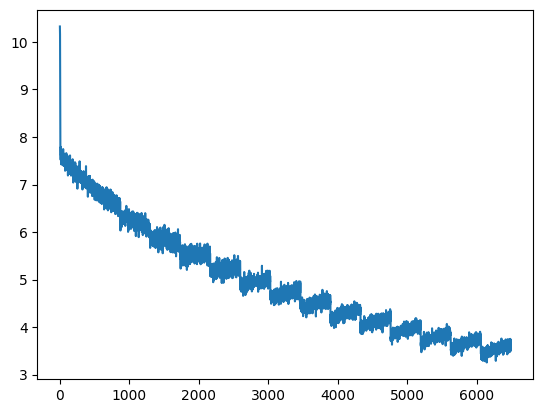

In [ ]:
plt.plot(trainer.train_loss)

## Inference

In [21]:
infer_model = Seq2Seq(src_tokenizer=title_tokenizer, tgt_tokenizer=poem_tokenizer, hidden_size=512, layers=2)
infer_model.load_state_dict(torch.load('models/pathfinder_seq2seq_model_512_l2_best.pt', weights_only=True))
infer_model.eval()

Seq2Seq(
  (src_emb): Embedding(30446, 512)
  (tgt_emb): Embedding(30447, 512)
  (encoder): GRU(512, 512, num_layers=2, batch_first=True, bidirectional=True)
  (decoder): GRU(512, 512, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (proj): Linear(in_features=512, out_features=30447, bias=True)
)

In [22]:
def top_p_sampling(logits, current_decoder_token, rep_pen=0.1, temperature=1.0, top_p=0.9):
    # Ensure logits are a PyTorch tensor and move to DEVICE

    # Apply temperature scaling
    scaled_logits = logits / temperature

    # Convert logits to probabilities using softmax
    probabilities = torch.softmax(scaled_logits, dim=-1)
    for tok_idx in current_decoder_token[0]:
                    # print(f"before: {probabilities[tok_idx]}")
                    probabilities[3] *= 1
                    probabilities[tok_idx] *= rep_pen
                    # print(f"after: {probabilities[tok_idx]}")
    # Sort probabilities and compute cumulative sum
    sorted_indices = torch.argsort(probabilities, descending=True)
    sorted_probabilities = probabilities[sorted_indices]
    cumulative_probabilities = torch.cumsum(sorted_probabilities, dim=-1)

    # Apply top-p filtering
    indices_to_keep = cumulative_probabilities <= top_p
    truncated_probabilities = sorted_probabilities[indices_to_keep]

    # Rescale the probabilities
    truncated_probabilities /= torch.sum(truncated_probabilities)

    # Convert to numpy arrays for random choice
    truncated_probabilities = truncated_probabilities.cpu().numpy()
    sorted_indices = sorted_indices.cpu().numpy()
    indices_to_keep = indices_to_keep.cpu().numpy()

    # Sample from the truncated distribution
    if not indices_to_keep.any():
        # Handle the empty case - for example, using regular sampling without top-p
        probabilities = torch.softmax(logits / temperature, dim=-1)
        next_word_index = torch.multinomial(probabilities, 1).item()
    else:
        # Existing sampling process
        next_word_index = np.random.choice(sorted_indices[indices_to_keep], p=truncated_probabilities)

    return torch.tensor(next_word_index).to('cpu')

def generate_text(model, seed_text, next_words,lines, temperature=1.0, top_p=0.9, rep_pen = 0.1):
    model.to('cpu')
    model.eval()
    with torch.inference_mode():
        input_tokens = title_tokenizer.encode(seed_text)
        
        predicted_tokens = []
        input_tensor = torch.LongTensor(input_tokens).unsqueeze(0)
        enc_out = model.encode(input_tensor)
        current_decoder_token = torch.LongTensor([[2]])
        for _ in range(lines):
            

            for _ in range(next_words):
                decoder_out = model.decode(current_decoder_token, enc_out)
                logit = model.proj(decoder_out[0, -1])
                sampled_token = top_p_sampling(logit, current_decoder_token, rep_pen, temperature, top_p)
                # sampled_token = torch.argmax(logit, dim=-1)
                current_decoder_token = torch.tensor(current_decoder_token[0].tolist() + [sampled_token], dtype=torch.long).unsqueeze(0)
                # output_word = poem_tokenizer.decode(sampled_token.item())
                if sampled_token == 3: ## end of sentence token
                    break
            newest_tokens = current_decoder_token.squeeze().tolist()[1:-1]
            # input_tokens = title_tokenizer.encode(seed_text)
            input_tensor = torch.LongTensor(newest_tokens).unsqueeze(0)
            current_decoder_token = torch.LongTensor([[2]])
            predicted_tokens.append(newest_tokens)
    output_poem = ""
    for line in predicted_tokens:
        line = poem_tokenizer.decode(line)
        output_poem += line + ' \n'

    return input_tokens, predicted_tokens, output_poem

In [31]:
input_tokens, pred_tokens, gen_poem = generate_text(infer_model, "sunset on the beach", next_words=30, lines=10, temperature=1.4, top_p=0.7, rep_pen=1)
print(f"input: {title_tokenizer.decode(input_tokens)}")
print(f"output: \n {gen_poem}") 

input: [CLS] sunset on the beach [SEP]
output: 
 whole roads fell on the hill the scarcity at 
thus on the radio stood tiptoe 
on full picture the dusk falls whitenover the deep into thunder 
stony satin the yellow spilled foam until until 
fish piles the bell extremely swoop 
fury of the canvas striking on 
houses fell over the edges on the road 
upturned corpses 
darkest on the deck break south a foot 
faint breaking on the crooked evening 

